# Getting Started : Optimal Transport Between Two Datasets

This short tutorial covers a basic use case for the `OTT` toolbox:

- Compute a optimal transport distance between two point clouds using the {class}`~ott.geometry.point_cloud.PointCloud` geometry and the {class}`~ott.solvers.linear.sinkhorn.Sinkhorn` algorithm. 
- Use the seamless integration with `JAX` to differentiate through that operation and plot the gradient flow to morph the first point cloud into the second.

## Imports and toy data definition

`OTT` is built on top of `JAX`, so we use `JAX` to instantiate all variables.

In [1]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

In [2]:
import jax
import jax.numpy as jnp

We generate randomly two 2D point clouds of 13 and 20 points respectively, and store them in variables `x` and `y` as matrices:

In [3]:
rngs = jax.random.split(jax.random.PRNGKey(0), 2)
d, n_x, n_y = 2, 7, 11
x = jax.random.normal(rngs[0], (n_x, d))
y = jax.random.normal(rngs[1], (n_y, d)) + 0.5
x_old = x

Because these point clouds are 2D dimensional, we can use scatter plots to illustrate them

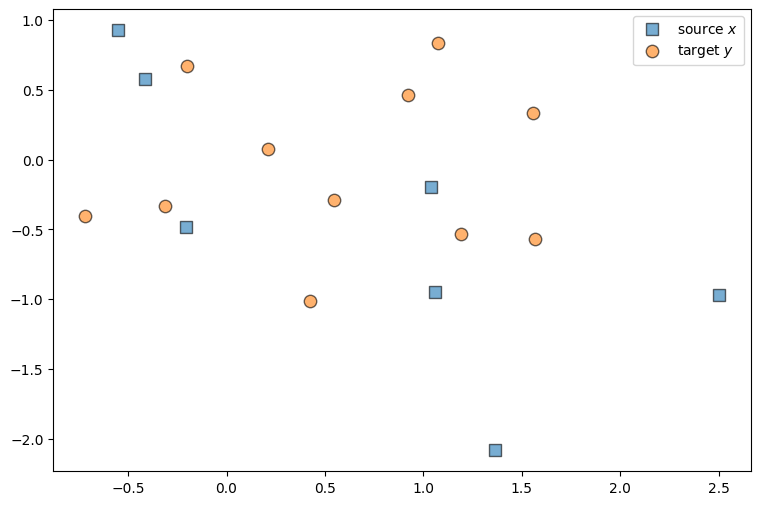

In [4]:
import matplotlib.pyplot as plt

x_args = {
    "s": 80,
    "label": r"source $x$",
    "marker": "s",
    "edgecolor": "k",
    "alpha": 0.6,
}
y_args = {"s": 80, "label": r"target $y$", "edgecolor": "k", "alpha": 0.6}
plt.figure(figsize=(9, 6))
plt.scatter(x[:, 0], x[:, 1], **x_args)
plt.scatter(y[:, 0], y[:, 1], **y_args)
plt.legend()
plt.show()

## Optimal transport with OTT

We will now use `ott` to compute the optimal transport between `x` and `y`. To do so, we first create a `geom` object that stores the geometry (a.k.a. the ground cost) between  `x` and `y`:

In [5]:
from ott.geometry import pointcloud

geom = pointcloud.PointCloud(x, y)

`geom` contains the two datasets `x` and `y`, as well as a `cost_fn` that is a way to measure distances between points. Here, we use the default settings, so the `cost_fn` is {class}`~ott.geometry.costs.SqEuclidean`, the usual squared-Euclidean distance.

In order to compute the optimal transport corresponding to `geom`, we use the Sinkhorn algorithm. The Sinkhorn algorithm has a regularization hyperparameter `epsilon`. `OTT` stores that parameter in `geom`, and uses by default the twentieth of the mean cost between all points in `x` and `y`. While it is also possible to set probably weights `a` for each point in `x` (and `b` for `y`), these are uniform by default.

In [6]:
from ott.solvers.linear import sinkhorn

ot = sinkhorn.solve(geom, a=None, b=None)

As a small note: the computations here are *jitted*, meaning that the second time the solver is run it will be much faster:

In [7]:
ot = sinkhorn.solve(geom)

The output object `ot` contains the solution of the optimal transport problems. This includes the transport plan matrix that indicates how much of the mass of the point `x[i]` is moved towards `y[j]`.

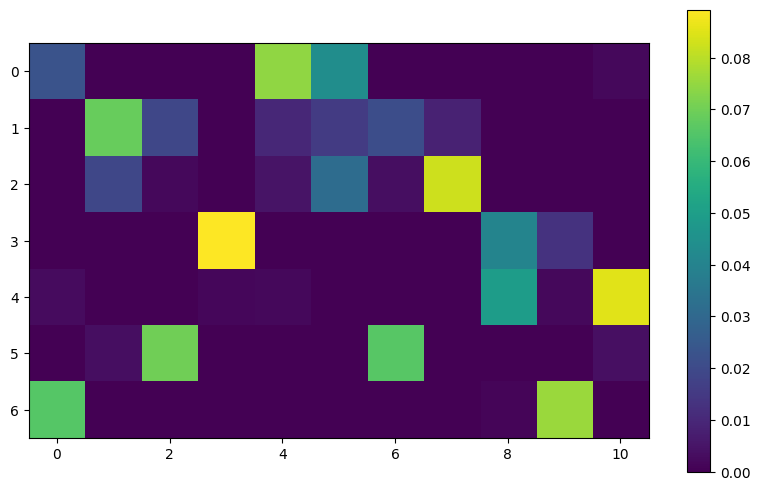

In [8]:
plt.figure(figsize=(10, 6))
plt.imshow(ot.matrix)
plt.colorbar()
plt.show()

As well as an estimation of the squared 2-Wasserstein metric between these two point clouds

In [9]:
ot.primal_cost, ot.dual_cost

(DeviceArray(1.0382653, dtype=float32), DeviceArray(0.5969251, dtype=float32))

## Automatic Differentiation using `JAX`

We finish this quick tour by illustrating one of the main features of `OTT`: it can be seamlessly integrated into differentiable end-to-end architectures built using `JAX`.

We provide a simple use-case where we differentiate the (regularized) OT transport cost w.r.t. `x`.

To do so, we define a function that takes `x` and `y` as input, and which output the loss.

In [10]:
def reg_ot_cost(x, y):
    geom = pointcloud.PointCloud(x, y)
    ot = sinkhorn.solve(geom)
    return ot.reg_ot_cost

Obtaining the gradient *function* of `reg_ot_cost` is as easy as making a call to `jax.grad` on `reg_ot_cost`, e.g. `jax.grad(reg_ot_cost)`. We use `jax.value_and_grad` here to also store the value of the output itself. Note that by default, `JAX` only computes by default the gradient w.r.t the *first* of variable of `reg_ot_cost` , here `x`.

In [11]:
# Value and gradient *function*
r_ot = jax.value_and_grad(reg_ot_cost)
# Evaluate it at `(x,y)`.
cost, grad_x = r_ot(x, y)
assert grad_x.shape == x.shape

This gradient, a matrix of the same size of `x`, describe gradient directions for each point in `x`.Following the opposite of that direction decreases the cost, to push point cloud `x` closer to `y`. This can be done iteratively, following a simple gradient flow that pushes `x` towards `y`.

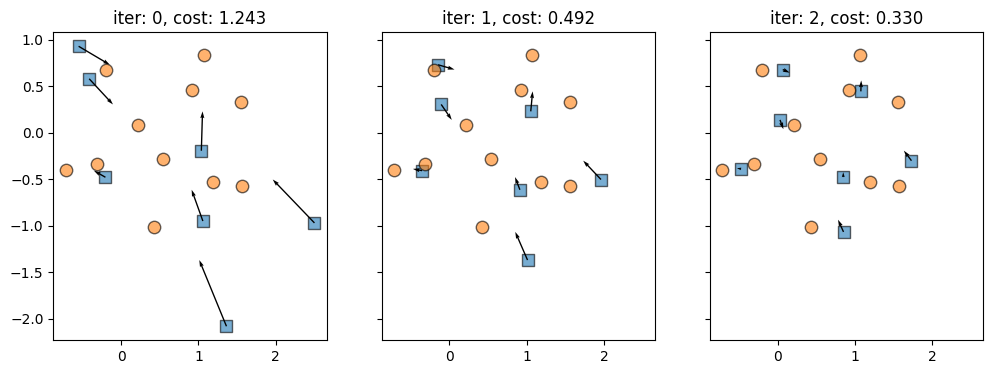

In [12]:
step_size = 2.0
x = x_old
quiv_args = {"scale": 1, "angles": "xy", "scale_units": "xy", "width": 0.005}
f, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(12, 4))
for iteration, ax in enumerate(axes):
    cost, grad_x = r_ot(x, y)
    ax.scatter(x[:, 0], x[:, 1], **x_args)
    ax.quiver(
        x[:, 0],
        x[:, 1],
        -step_size * grad_x[:, 0],
        -step_size * grad_x[:, 1],
        **quiv_args,
    )
    ax.scatter(y[:, 0], y[:, 1], **y_args)
    ax.set_title(f"iter: {iteration}, cost: {cost:.3f}")
    x -= step_size * grad_x

# Going further

This tutorial gave you a glimpse of the most basic features of `OTT` and how they integrate with `JAX`.
`OTT` implements many other functionalities, including extensions of the base optimal transport problem such as, for instance,
- More general [cost functions](https://ott-jax.readthedocs.io/en/latest/tutorials/notebooks/point_clouds.html),
- [Gromov-Wasserstein distances](https://ott-jax.readthedocs.io/en/latest/tutorials/notebooks/gromov_wasserstein.html) to compare distributions defined on incomparable spaces.
- [Low-rank Sinkhorn](https://ott-jax.readthedocs.io/en/latest/tutorials/notebooks/LRSinkhorn.html) solvers that are much faster, thanks to a low-rank constraint on coupling matrices,
- [Wasserstein barycenters of distributions](https://ott-jax.readthedocs.io/en/latest/tutorials/notebooks/wasserstein_barycenters_gmms.html),
- [Differentiable sorting procedures](https://ott-jax.readthedocs.io/en/latest/tutorials/notebooks/soft_sort.html),
- [Neural dual solvers](https://ott-jax.readthedocs.io/en/latest/tutorials/notebooks/neural_dual.html) to estimate maps in functional form.